# Full Motif Analysis: Motif Zoo & Cross-Task Comparison

This notebook loads the pipeline results from `data/results/` and presents:
1. **Motif Zoo** — summary statistics for each triad class across all 99 graphs
2. **Z-score heatmap** — mean Z-scores by task category × motif class
3. **Task similarity** — cosine similarity matrix and dendrogram
4. **Interesting graphs** — graphs with extreme motif enrichment patterns
5. **Neuronpedia-style plots** — attribution graphs with highlighted motif instances

**Prerequisite:** Run the pipeline first:
```bash
python -m src.pipeline --n-random 100
```

In [1]:
import sys
sys.path.insert(0, "..")

import json
import pickle
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.graph_loader import load_attribution_graph
from src.motif_census import (
    TRIAD_LABELS, CONNECTED_TRIAD_INDICES,
    MOTIF_FFL, MOTIF_CHAIN, MOTIF_FAN_IN, MOTIF_FAN_OUT,
    find_motif_instances,
)
from src.visualization import (
    plot_zscore_heatmap,
    plot_sp_heatmap,
    plot_task_dendrogram,
    plot_cosine_similarity_matrix,
    plot_grouped_bar,
    plot_top_motif,
)

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

## 1. Load Pipeline Results

In [2]:
results_dir = Path("../data/results")

# Load analysis summary (JSON)
with open(results_dir / "analysis_summary.json") as f:
    summary = json.load(f)

# Load task profiles (pickle — needed for visualization functions)
with open(results_dir / "task_profiles.pkl", "rb") as f:
    task_profiles = pickle.load(f)

# Load clustering
with open(results_dir / "clustering.pkl", "rb") as f:
    clustering = pickle.load(f)

# Load per-graph results
with open(results_dir / "per_graph_results.pkl", "rb") as f:
    per_graph = pickle.load(f)

print(f"Loaded results for {len(summary['graphs'])} graphs across {len(task_profiles)} categories")
for name, profile in sorted(task_profiles.items()):
    print(f"  {name}: {profile.n_graphs} graphs")

Loaded results for 99 graphs across 9 categories
  arithmetic: 14 graphs
  code: 4 graphs
  creative: 3 graphs
  factual_recall: 27 graphs
  multihop: 10 graphs
  multilingual: 6 graphs
  reasoning: 14 graphs
  safety: 11 graphs
  uncategorized: 10 graphs


## 2. Motif Zoo — Summary Statistics

For each of the 15 connected triad classes, we show:
- Mean/median Z-score across all graphs
- What percentage of graphs show enrichment (Z > 2) or depletion (Z < -2)
- Range of Z-scores observed

In [3]:
zoo = summary["motif_zoo"]["motif_summary"]

print(f"{'Motif':<8s}  {'Mean Z':>7s}  {'Med Z':>7s}  {'Min Z':>7s}  {'Max Z':>7s}  "
      f"{'Enriched':>8s}  {'Depleted':>8s}  {'N':>3s}")
print("-" * 75)
for m in zoo:
    print(f"{m['label']:<8s}  {m['mean_z']:>+7.2f}  {m['median_z']:>+7.2f}  "
          f"{m['min_z']:>+7.1f}  {m['max_z']:>+7.1f}  "
          f"{m['pct_enriched']:>7.1f}%  {m['pct_depleted']:>7.1f}%  "
          f"{m['n_graphs']:>3d}")

Motif      Mean Z    Med Z    Min Z    Max Z  Enriched  Depleted    N
---------------------------------------------------------------------------
030T       +26.17   +22.10     +2.7    +75.0    100.0%      0.0%   99
021C       +20.13   +17.85     -6.4    +63.0     96.0%      1.0%   99
111U       -17.37   -14.95    -56.8     -1.7      0.0%     99.0%   99
120C       -17.23   -13.71    -53.3     -1.0      0.0%     99.0%   99
111D       -15.96   -13.84    -43.5     -1.5      0.0%     99.0%   99
120D       -15.15   -12.40    -45.5     -1.3      0.0%     99.0%   99
120U       -14.91   -13.20    -45.5     -1.1      0.0%     99.0%   99
021D       -11.07    -8.95    -37.9     +4.6      7.1%     80.8%   99
030C        -9.49    -7.77    -31.6     -1.2      0.0%     97.0%   99
210         -9.04    -7.31    -29.2     -0.5      0.0%     91.9%   99
201         -7.12    -6.00    -26.1     -0.6      0.0%     93.9%   99
300         -3.30    -2.61    -11.6     +0.0      0.0%     63.6%   99
021U        -0

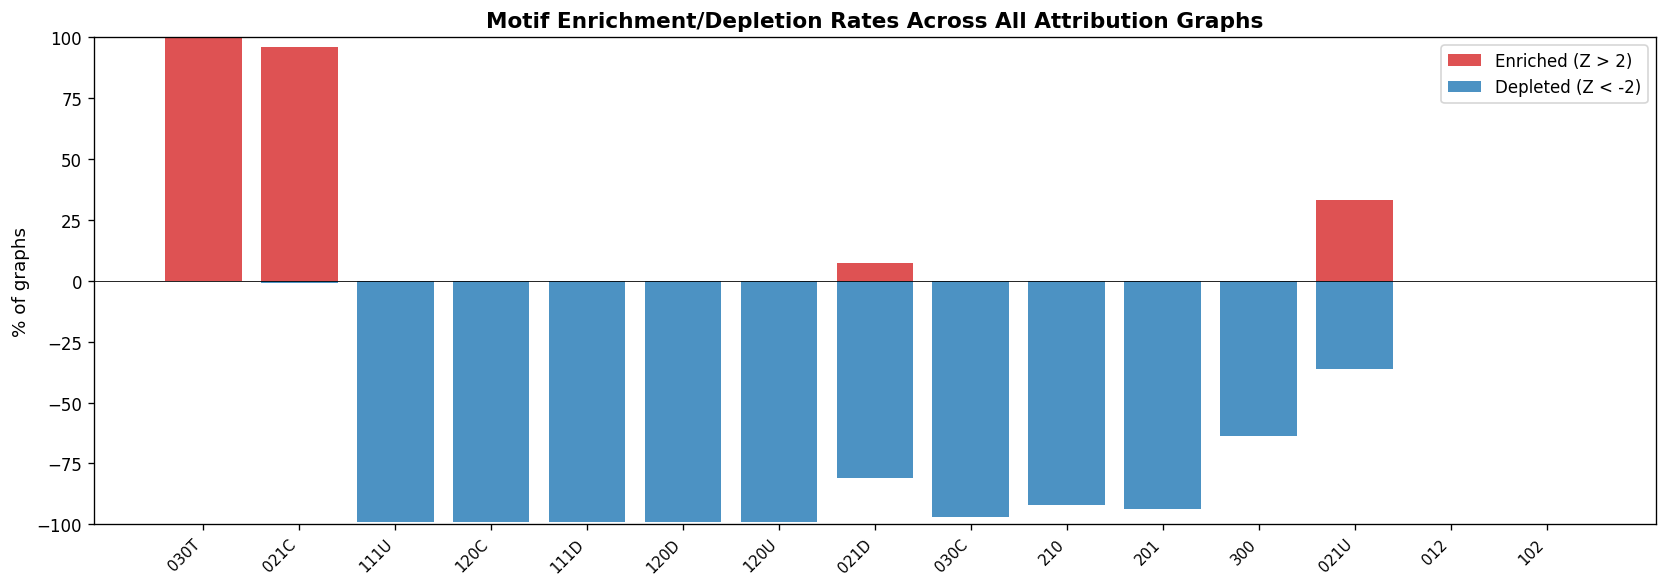

In [4]:
# Bar chart of enrichment/depletion rates across motifs
labels = [m['label'] for m in zoo]
enriched = [m['pct_enriched'] for m in zoo]
depleted = [-m['pct_depleted'] for m in zoo]  # negative for visual

fig, ax = plt.subplots(figsize=(14, 5))
x = np.arange(len(labels))
ax.bar(x, enriched, color='#d62728', alpha=0.8, label='Enriched (Z > 2)')
ax.bar(x, depleted, color='#1f77b4', alpha=0.8, label='Depleted (Z < -2)')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
ax.set_ylabel('% of graphs', fontsize=11)
ax.set_title('Motif Enrichment/Depletion Rates Across All Attribution Graphs', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.set_ylim(-100, 100)
plt.tight_layout()
plt.show()

## 3. Z-Score Distribution per Motif

Violin plots showing the distribution of Z-scores for each motif class across all graphs.

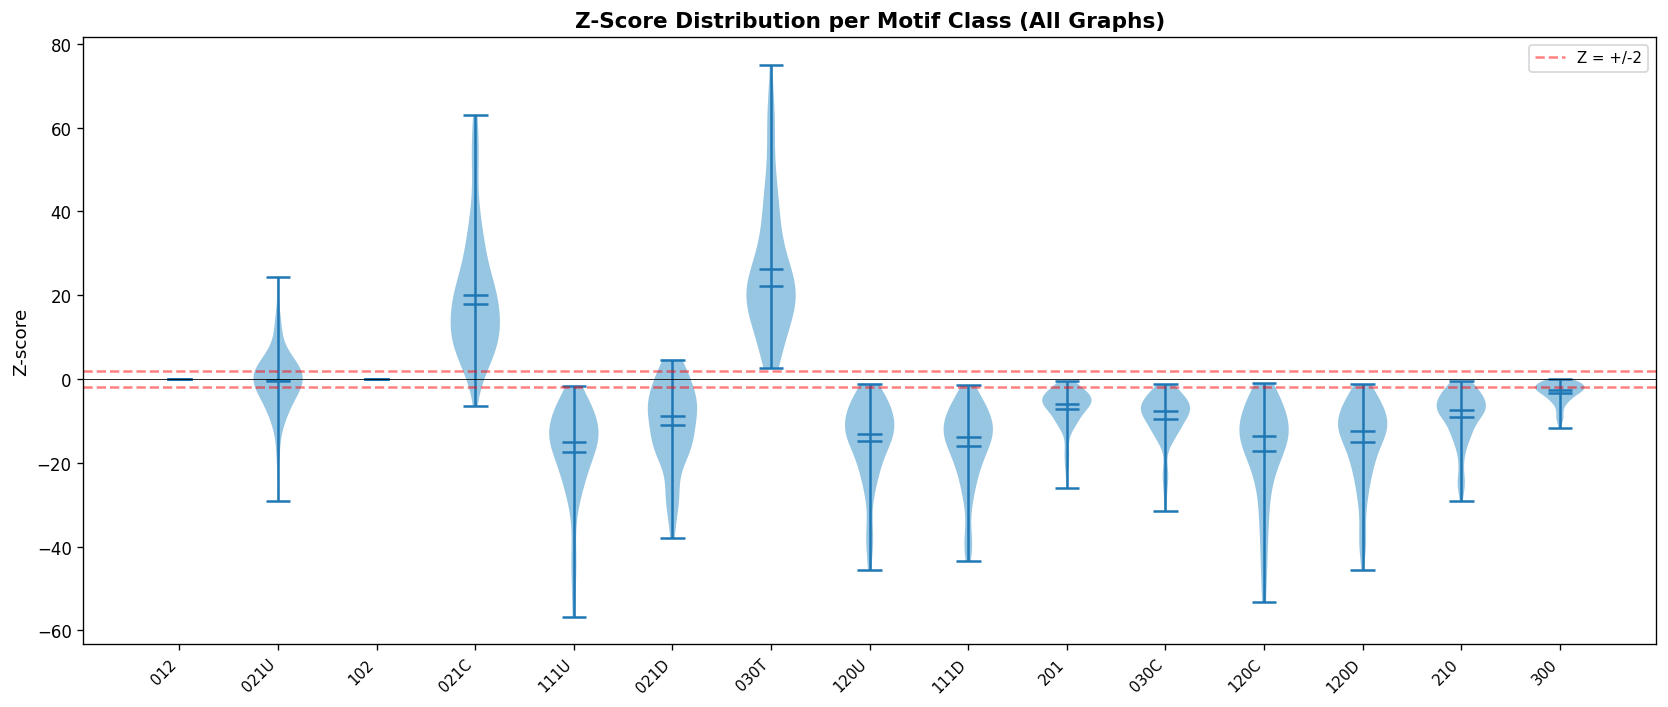

In [5]:
# Collect all Z-scores per motif
motif_labels = [TRIAD_LABELS[i] for i in CONNECTED_TRIAD_INDICES]
z_data = {label: [] for label in motif_labels}

for g in summary['graphs']:
    for label in motif_labels:
        z = g['z_scores'].get(label, 0)
        if np.isfinite(z):
            z_data[label].append(z)

fig, ax = plt.subplots(figsize=(14, 6))
positions = list(range(len(motif_labels)))
parts = ax.violinplot(
    [z_data[label] for label in motif_labels],
    positions=positions,
    showmeans=True,
    showmedians=True,
)

# Color the violin bodies
for pc in parts['bodies']:
    pc.set_facecolor('#6baed6')
    pc.set_alpha(0.7)

ax.axhline(2.0, color='red', linestyle='--', alpha=0.5, label='Z = +/-2')
ax.axhline(-2.0, color='red', linestyle='--', alpha=0.5)
ax.axhline(0, color='black', linewidth=0.5)
ax.set_xticks(positions)
ax.set_xticklabels(motif_labels, rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Z-score', fontsize=11)
ax.set_title('Z-Score Distribution per Motif Class (All Graphs)', fontsize=13, fontweight='bold')
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

## 4. Cross-Task Z-Score Heatmap

The main result figure: mean Z-scores for each task category × motif class.
Red = enriched, blue = depleted.

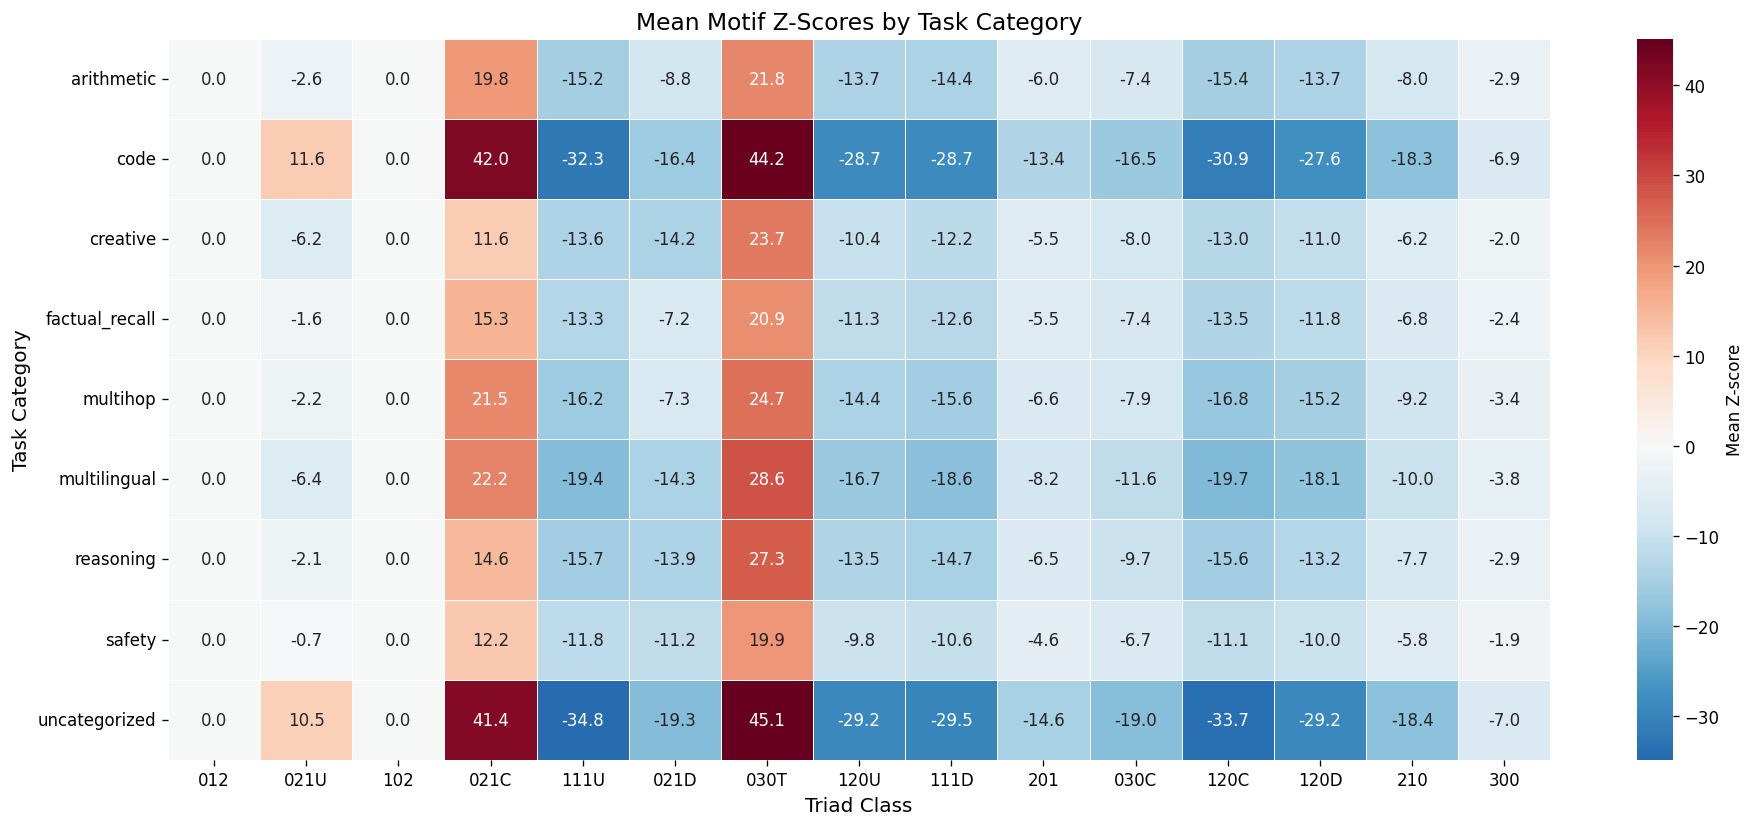

In [6]:
fig = plot_zscore_heatmap(
    task_profiles,
    title='Mean Motif Z-Scores by Task Category',
    figsize=(16, 7),
)
plt.show()

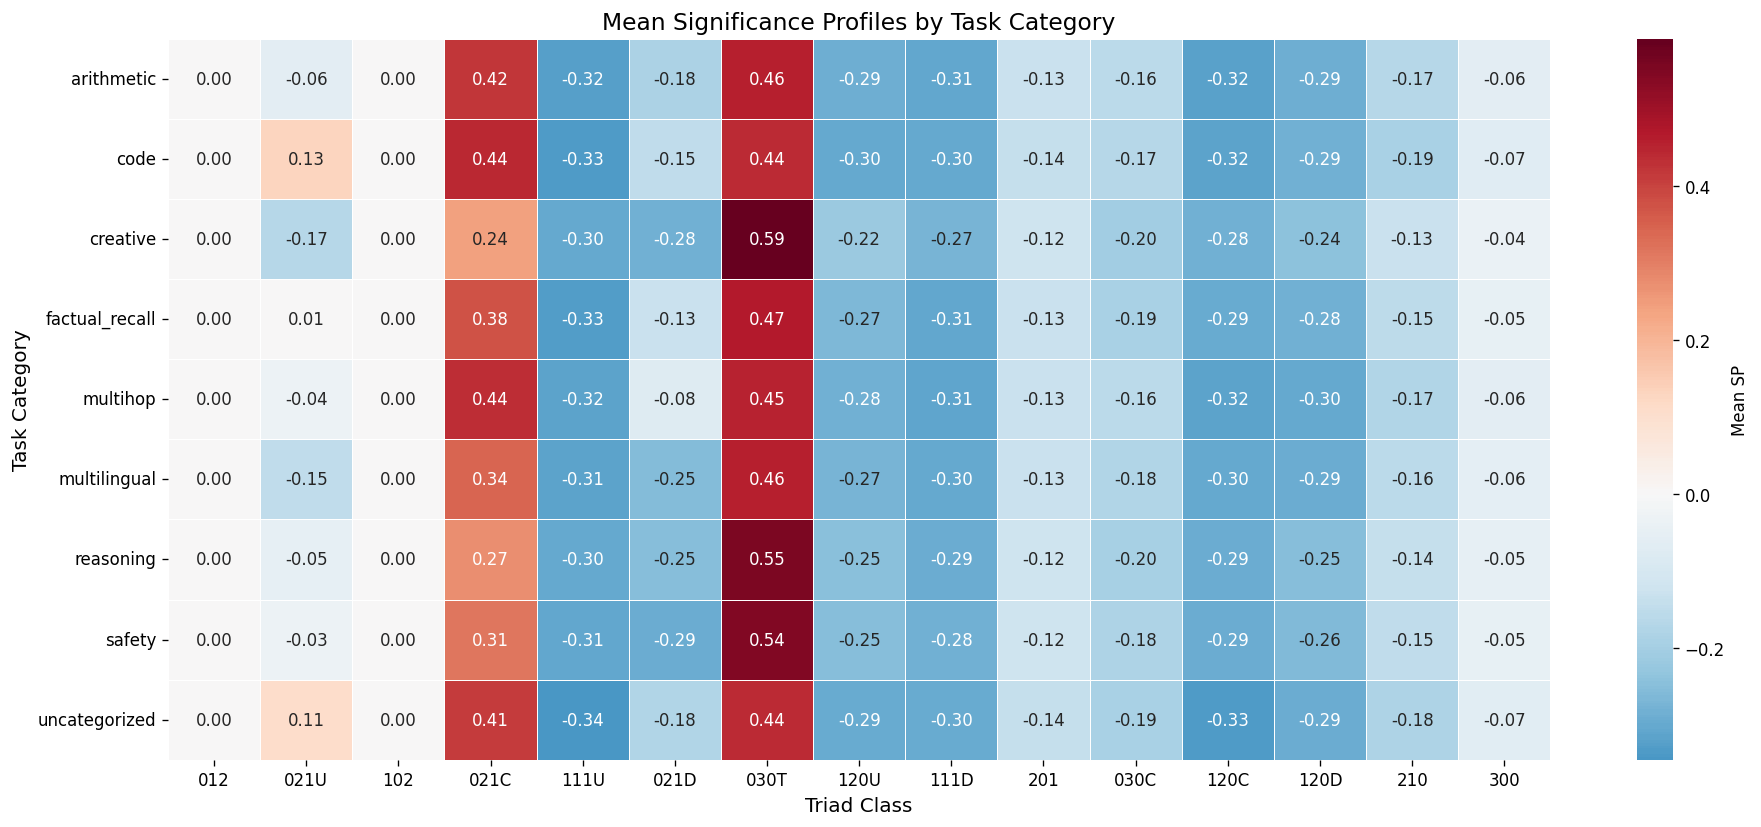

In [7]:
fig = plot_sp_heatmap(
    task_profiles,
    title='Mean Significance Profiles by Task Category',
    figsize=(16, 7),
)
plt.show()

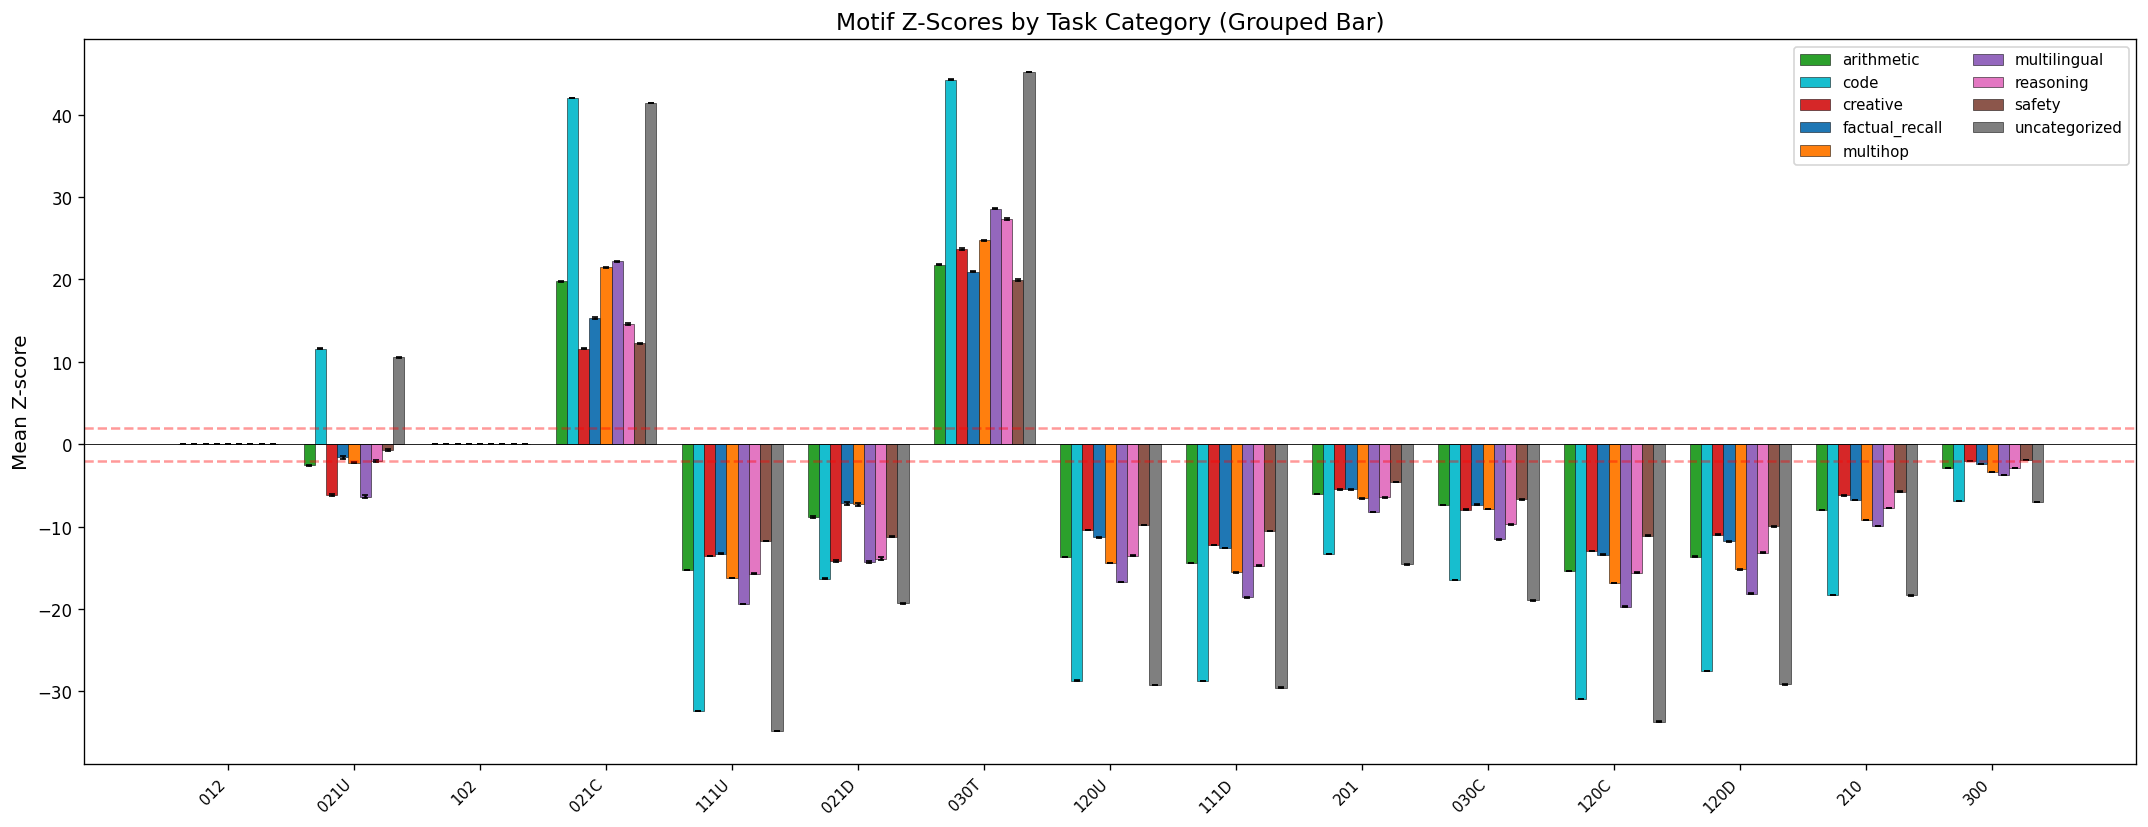

In [8]:
fig = plot_grouped_bar(
    task_profiles,
    title='Motif Z-Scores by Task Category (Grouped Bar)',
    figsize=(18, 7),
)
plt.show()

## 5. Task Similarity & Clustering

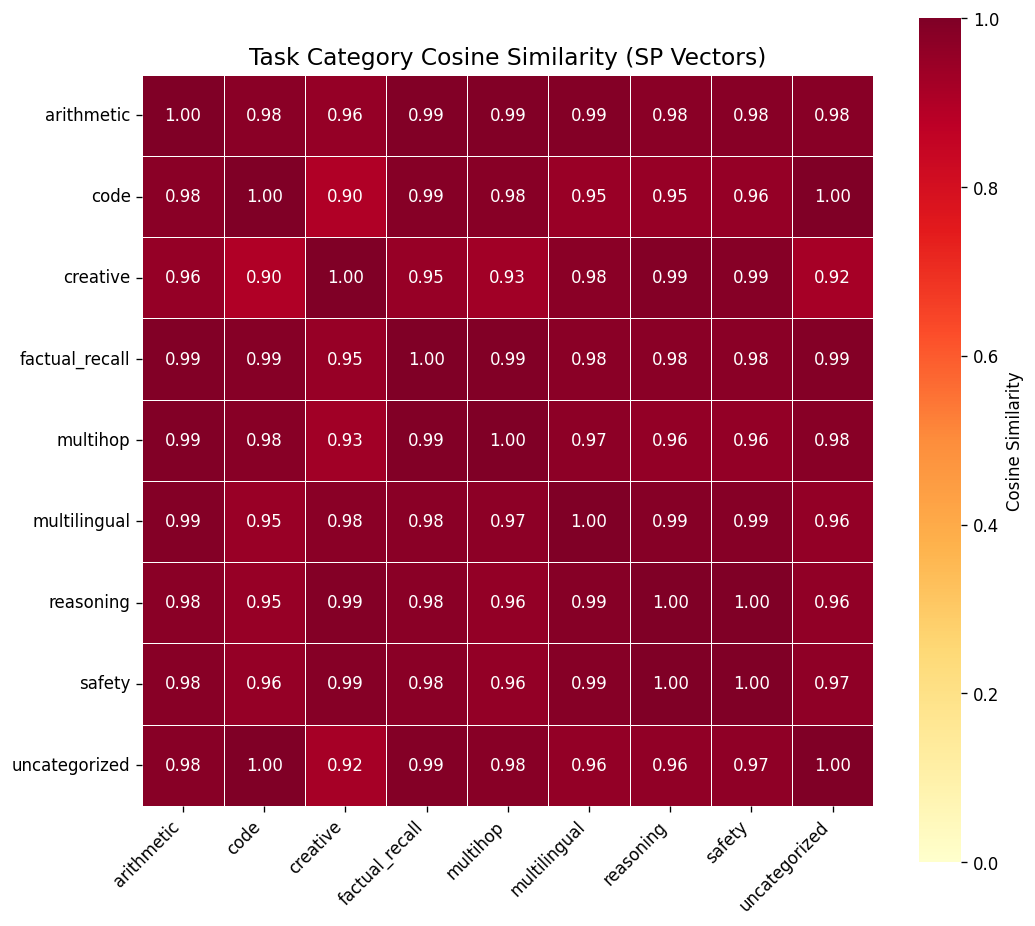

In [9]:
sim_data = summary['similarity_matrix']
sim_matrix = np.array(sim_data['matrix'])
task_names = sim_data['task_names']

fig = plot_cosine_similarity_matrix(
    sim_matrix, task_names,
    title='Task Category Cosine Similarity (SP Vectors)',
    figsize=(9, 8),
)
plt.show()

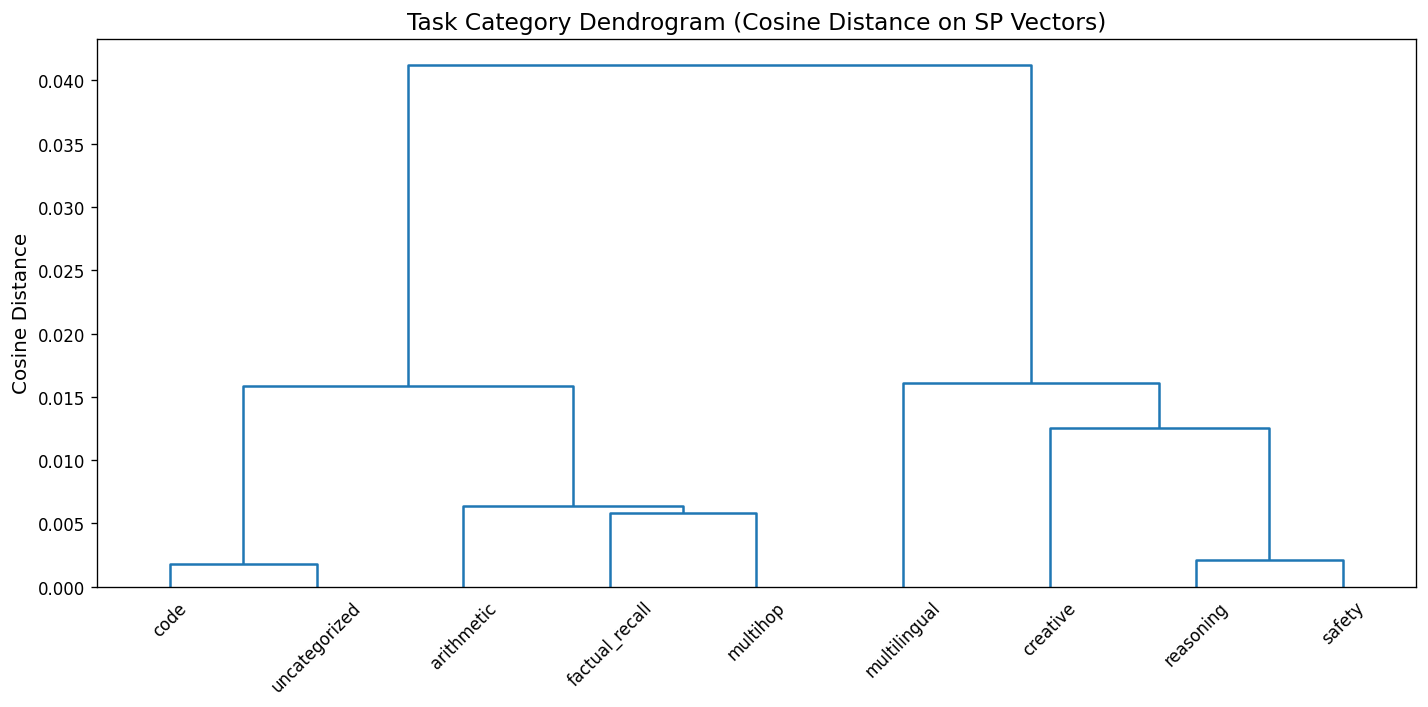

In [10]:
linkage_matrix = clustering['linkage']
cluster_names = clustering['names']

if len(linkage_matrix) > 0:
    fig = plot_task_dendrogram(
        linkage_matrix, cluster_names,
        title='Task Category Dendrogram (Cosine Distance on SP Vectors)',
        figsize=(12, 6),
    )
    plt.show()
else:
    print('Not enough categories for clustering.')

## 6. Kruskal-Wallis Test Results

Which motif classes differ significantly across task categories?

In [11]:
kw = summary['kruskal_wallis']

print(f"{'Motif':<8s}  {'H-stat':>8s}  {'p-value':>10s}  {'Significant':>11s}")
print('-' * 42)
for r in kw:
    if r['motif_index'] not in CONNECTED_TRIAD_INDICES:
        continue
    sig = 'YES ***' if r['significant'] else 'no'
    h = f"{r['H_statistic']:.2f}" if np.isfinite(r['H_statistic']) else 'N/A'
    p = f"{r['p_value']:.4f}" if np.isfinite(r['p_value']) else 'N/A'
    print(f"{r['label']:<8s}  {h:>8s}  {p:>10s}  {sig:>11s}")

Motif       H-stat     p-value  Significant
------------------------------------------
012            N/A         N/A           no
021U         24.57      0.0018      YES ***
102            N/A         N/A           no
021C         30.58      0.0002      YES ***
111U         16.79      0.0323      YES ***
021D         16.57      0.0349      YES ***
030T         21.42      0.0061      YES ***
120U         20.84      0.0076      YES ***
111D         11.01      0.2014           no
201          16.64      0.0341      YES ***
030C         18.57      0.0173      YES ***
120C          6.87      0.5511           no
120D         17.88      0.0221      YES ***
210          30.86      0.0001      YES ***
300          27.80      0.0005      YES ***


## 7. Most Interesting Graphs

Graphs ranked by maximum absolute Z-score — these have the most extreme motif enrichment patterns.

In [12]:
interesting = summary['motif_zoo']['interesting_graphs']

print(f"{'Rank':>4s}  {'Category':<18s}  {'Name':<35s}  {'Max |Z|':>7s}  {'# Sig':>5s}  {'Nodes':>5s}  {'Edges':>5s}")
print('-' * 95)
for i, g in enumerate(interesting[:20]):
    print(f"{i+1:>4d}  {g['category']:<18s}  {g['name']:<35s}  {g['max_abs_z']:>7.1f}  "
          f"{g['n_significant_motifs']:>5d}  {g['n_nodes']:>5d}  {g['n_edges']:>5d}")

Rank  Category            Name                                 Max |Z|  # Sig  Nodes  Edges
-----------------------------------------------------------------------------------------------
   1  uncategorized       pmb-50-plt                              75.0     13    369  27725
   2  uncategorized       pmb-179-plt                             68.7     13    433  31265
   3  code                pandas-group-plt-clean                  63.9     13    284  14548
   4  uncategorized       pmb-99-plt                              63.0     13    358  23438
   5  code                str-indexing-pos-0-plt-clean            62.9     13    232  10673
   6  reasoning           sally-school-plt-clean                  61.5     13    368  27481
   7  uncategorized       pmb-29-plt                              60.1     12    220  10501
   8  uncategorized       pmb-37-plt                              57.7     13    281  14674
   9  multilingual        season-after-spring-fr-plt-clean        53.0     1

## 8. Neuronpedia-Style Visualization of Top Interesting Graphs

We pick the top-ranked interesting graphs and show their attribution graph
with the highest-weight feedforward loop (FFL) motif highlighted.


Graph #1: uncategorized/pmb-50-plt
Max |Z|=75.0, 13 significant motifs
Prompt: types, such as a front projection type and a rear projection type, depending on how images are 
Pruned graph: 369 nodes, 41 edges
Found 15 FFL instances
Top FFL weight: 8.7
  regulator   :  (layer 17)
  mediator    :  (layer 16)
  target      :  (layer 15)


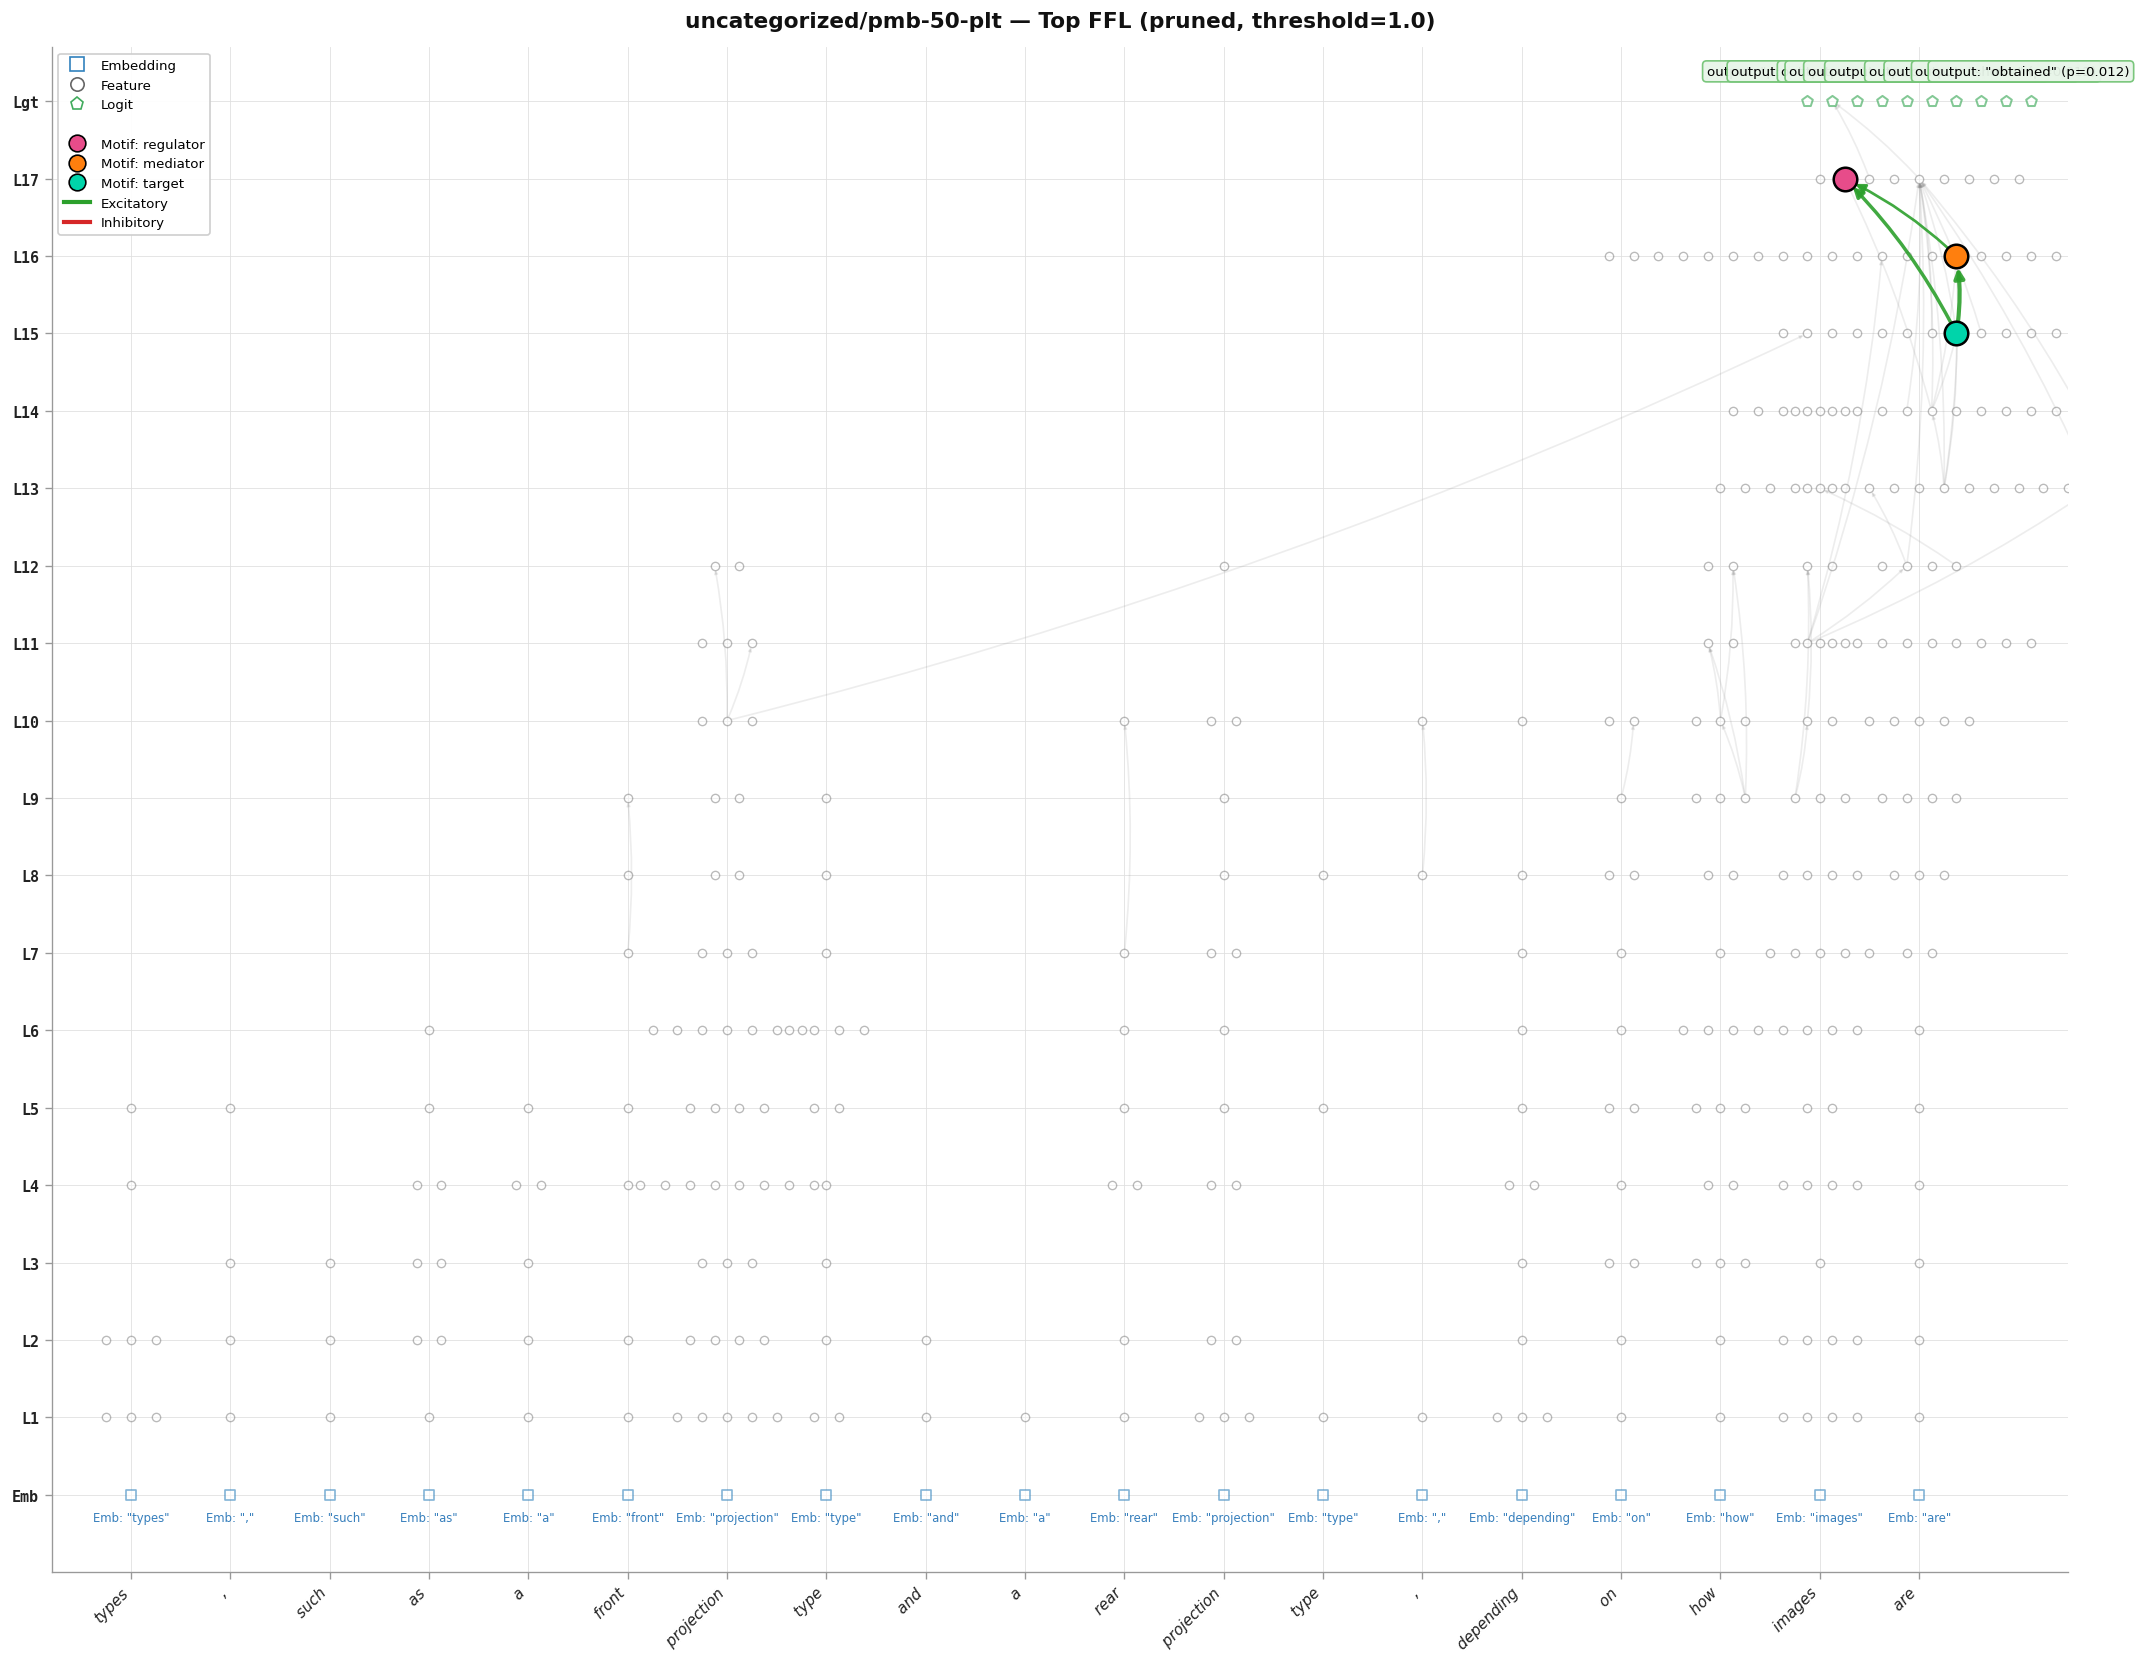


Graph #2: uncategorized/pmb-179-plt
Max |Z|=68.7, 13 significant motifs
Prompt: invention.
In a separate aspect, the invention provides a method of potentiating the actions of othe
Pruned graph: 433 nodes, 130 edges
Found 108 FFL instances
Top FFL weight: 50.3
  regulator   :  (layer 17)
  mediator    :  (layer 15)
  target      :  (layer 12)


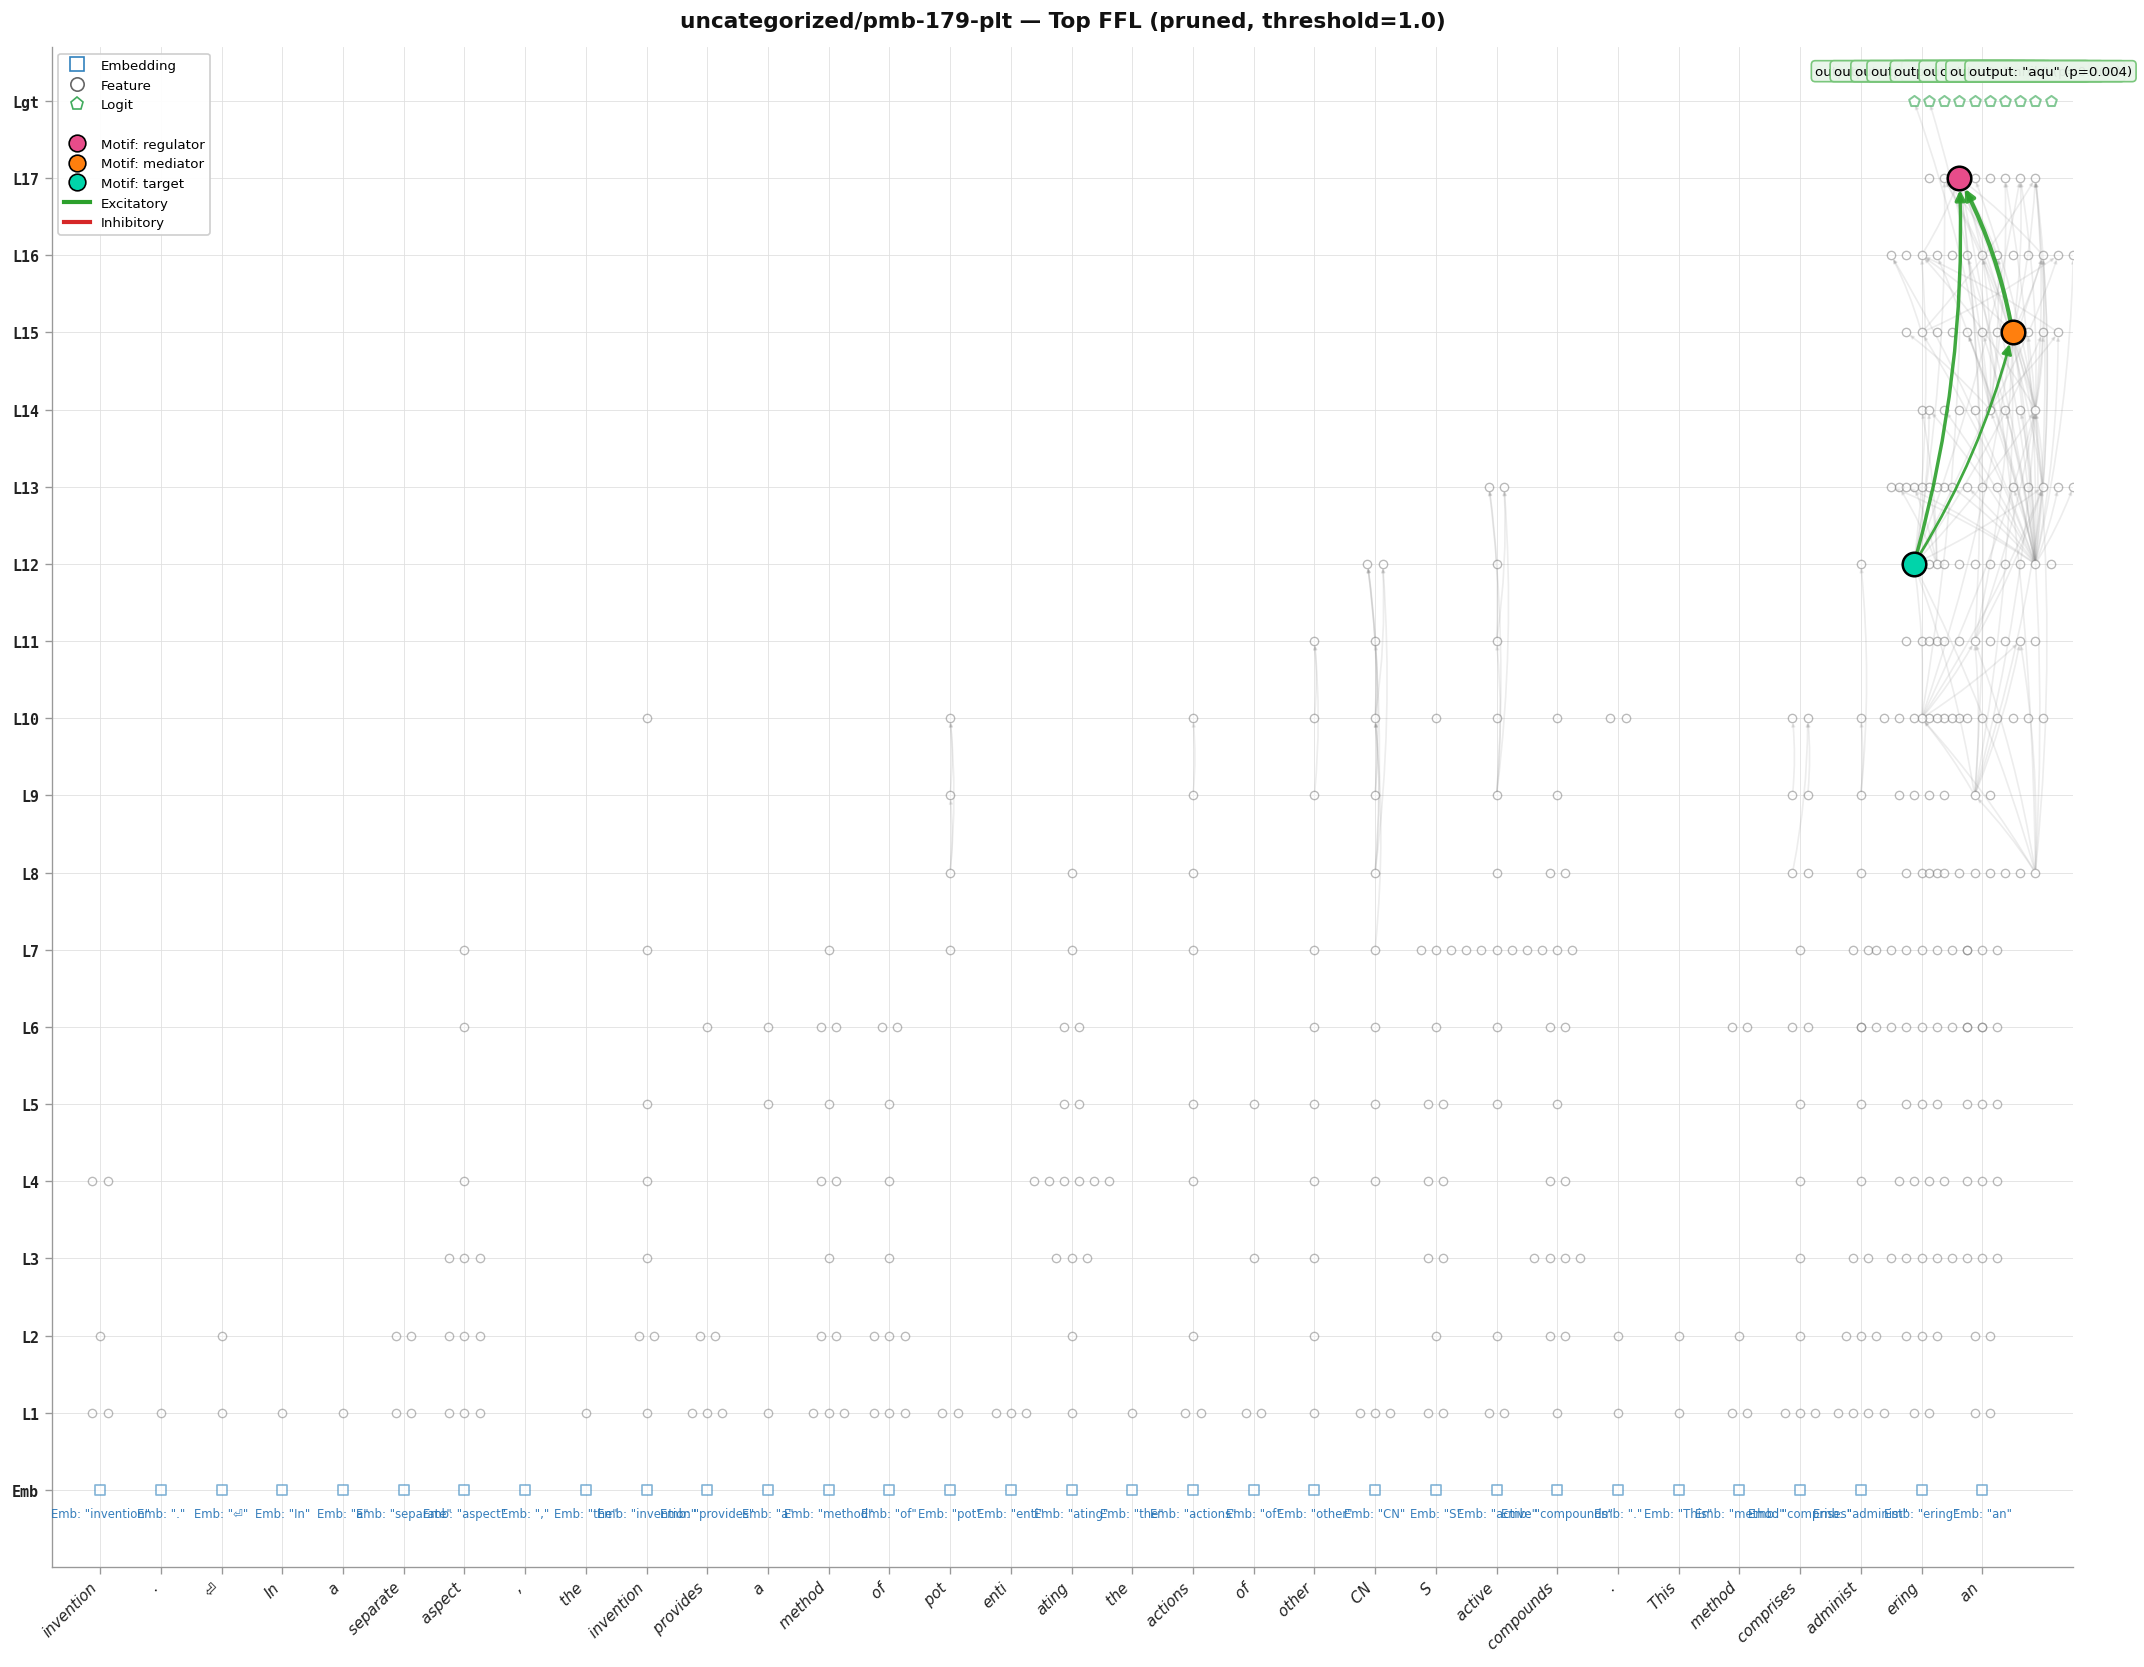


Graph #3: code/pandas-group-plt-clean
Max |Z|=63.9, 13 significant motifs
Prompt: def customer_spending(transaction_df):
    for customer_id, customer_df in transaction_df.
Pruned graph: 284 nodes, 85 edges
Found 28 FFL instances
Top FFL weight: 9.6
  regulator   :  (layer 17)
  mediator    :  (layer 15)
  target      :  (layer 14)


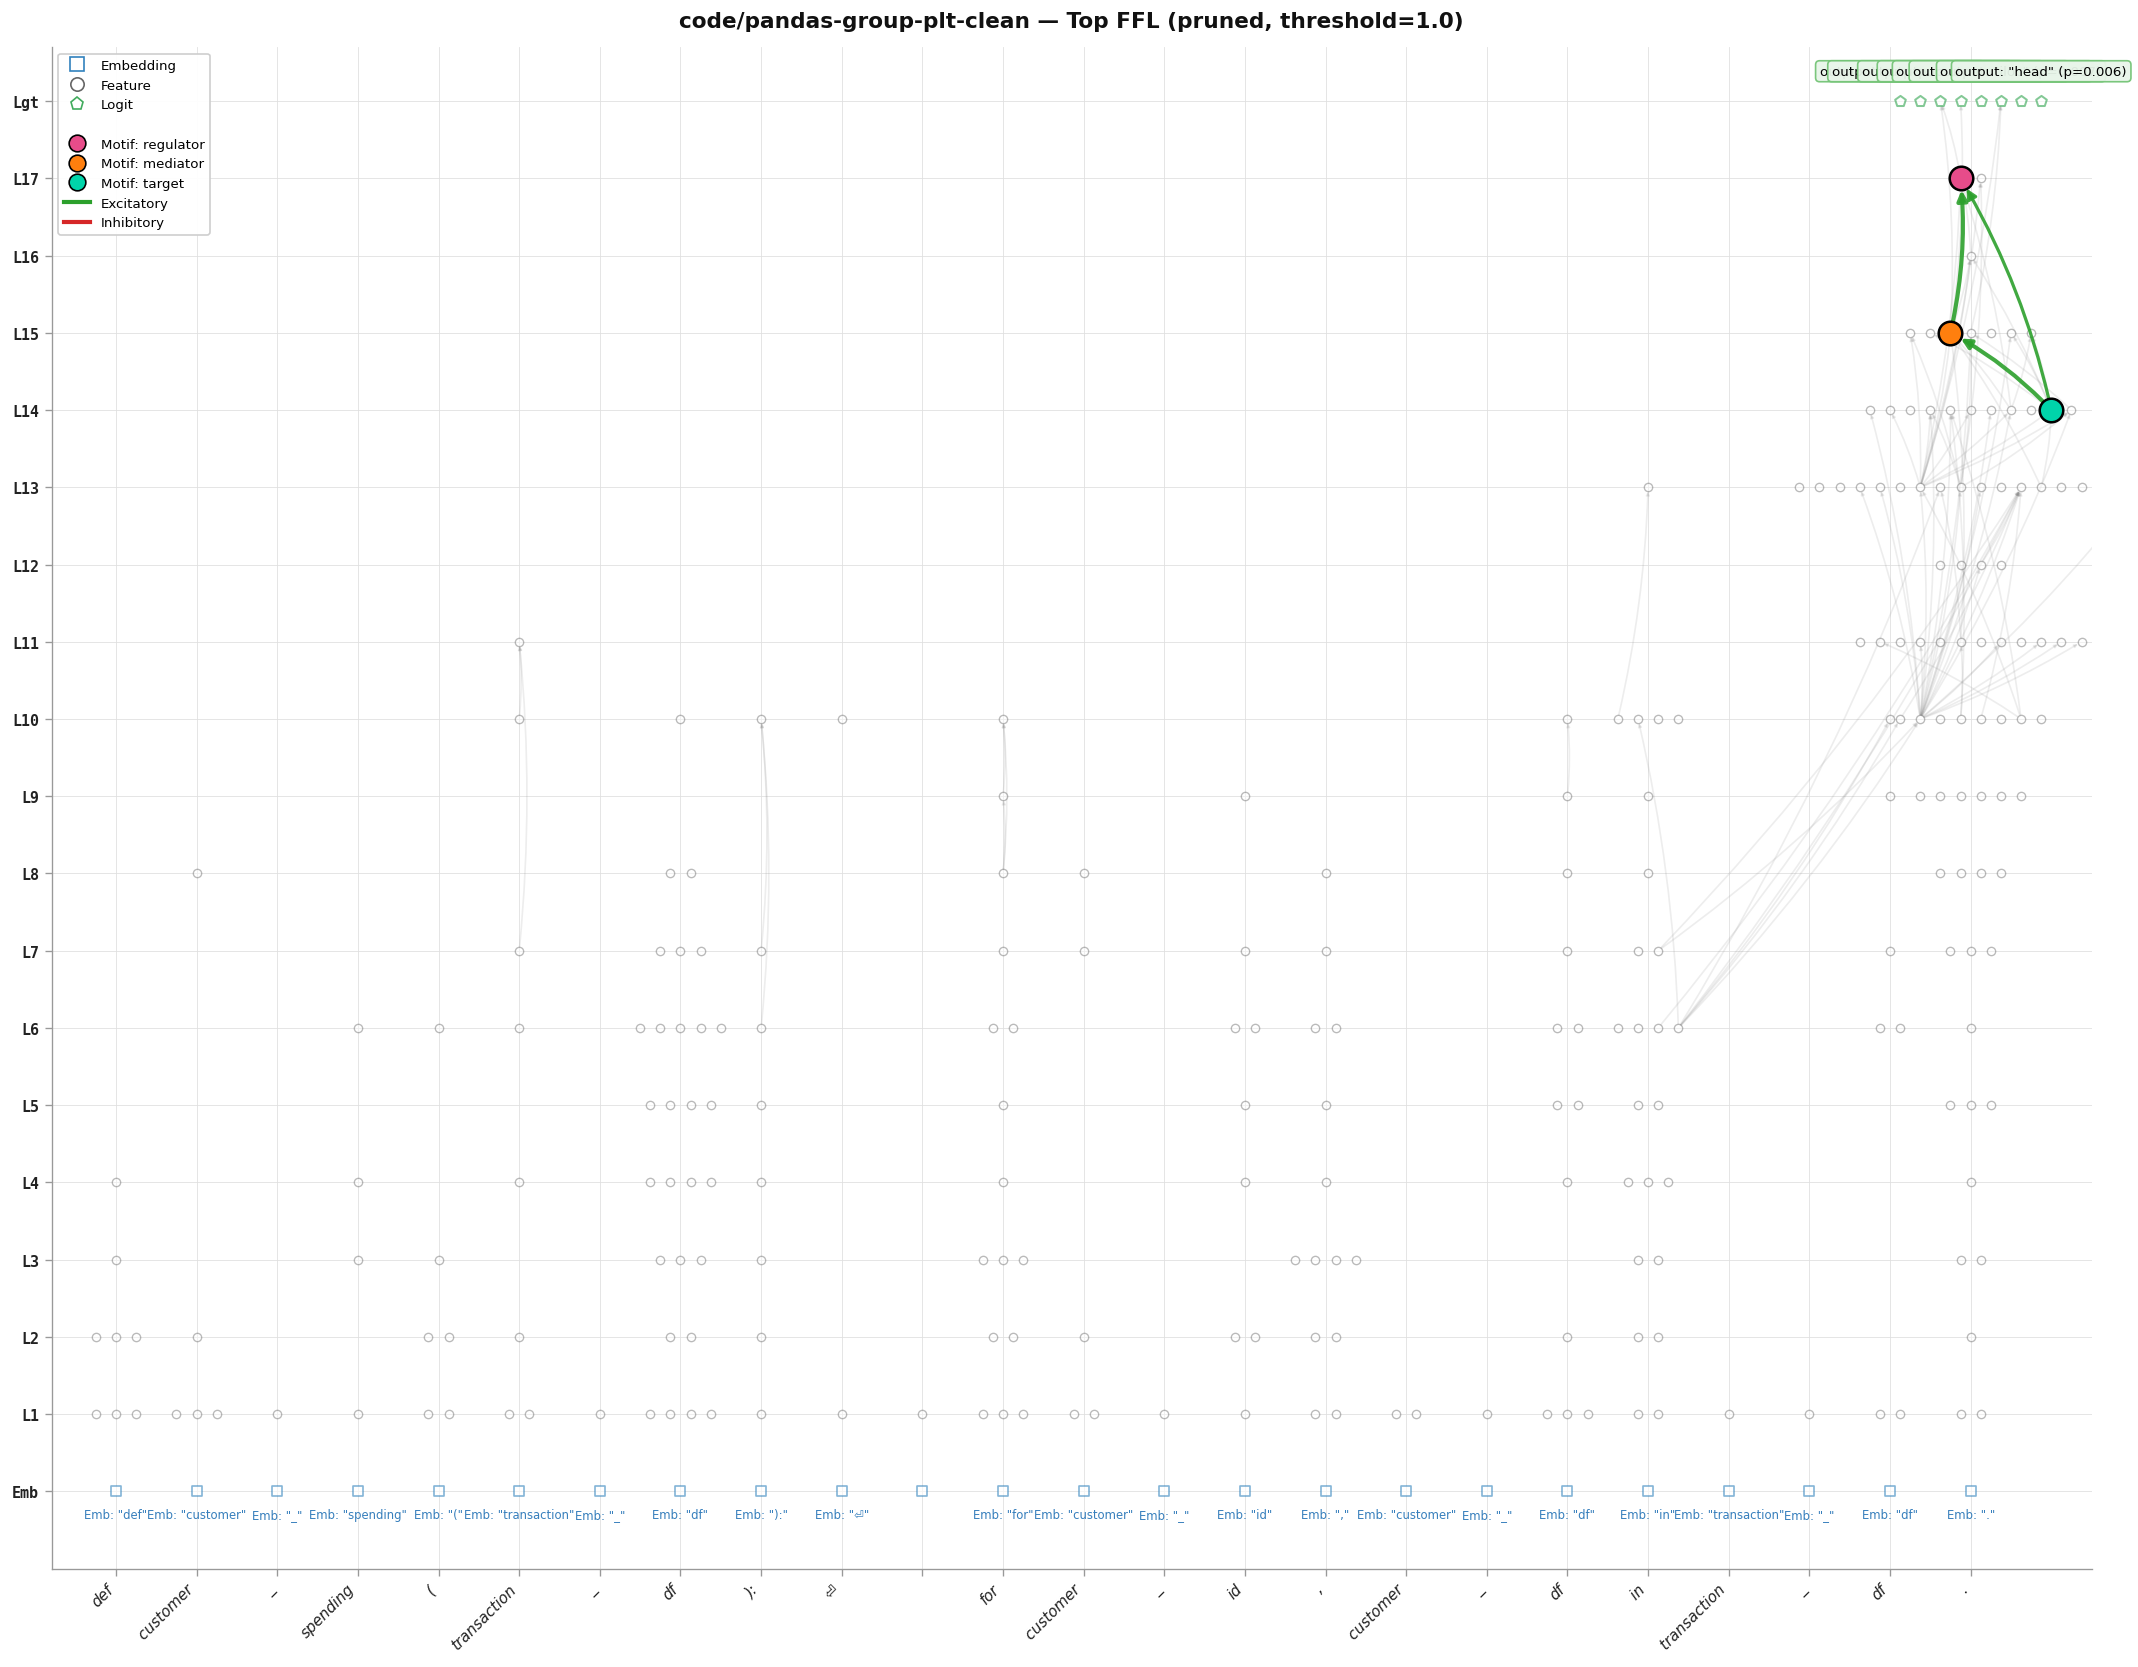

In [13]:
# Find the per-graph result entries for the top interesting graphs
def find_graph_path(per_graph, category, name):
    """Find the file path for a graph by category and name.
    
    Paths stored in pipeline results are relative to project root,
    so we prepend '..' since the notebook runs from notebooks/.
    """
    for r in per_graph.get(category, []):
        if r['name'] == name:
            return Path("..") / r['path']
    return None


# Show attribution graphs for top 3 interesting graphs
n_show = min(3, len(interesting))
for i in range(n_show):
    info = interesting[i]
    path = find_graph_path(per_graph, info['category'], info['name'])
    if path is None:
        print(f"Could not find path for {info['name']}")
        continue

    print(f"\n{'='*70}")
    print(f"Graph #{i+1}: {info['category']}/{info['name']}")
    print(f"Max |Z|={info['max_abs_z']:.1f}, "
          f"{info['n_significant_motifs']} significant motifs")
    print(f"Prompt: {info['prompt']}")
    print(f"{'='*70}")

    # Load with pruning for clearer visualization
    g = load_attribution_graph(path, weight_threshold=1.0)
    print(f"Pruned graph: {g.vcount()} nodes, {g.ecount()} edges")

    # Try FFL first, then chain
    for motif_name, motif_id in [('FFL', MOTIF_FFL), ('Chain', MOTIF_CHAIN)]:
        instances = find_motif_instances(g, motif_id, sort_by='weight')
        if instances:
            print(f"Found {len(instances)} {motif_name} instances")
            fig, inst = plot_top_motif(
                g, motif_id, rank=0,
                title=f"{info['category']}/{info['name']} — Top {motif_name} (pruned, threshold=1.0)",
                figsize=(18, 14),
            )
            print(f"Top {motif_name} weight: {inst.total_weight:.1f}")
            for node_idx, role in inst.node_roles.items():
                print(f"  {role:12s}: {g.vs[node_idx]['clerp']} (layer {g.vs[node_idx]['layer']})")
            plt.show()
            break
    else:
        print("No FFL or Chain instances found in pruned graph.")

## 9. Per-Category Motif Instance Counts

How many motif instances of each type appear per category (averaged over graphs)?

In [14]:
# Aggregate instance counts by category
instance_types = ['FFL', 'chain', 'fan_in', 'fan_out', 'cycle']

print(f"{'Category':<18s}  {'N':>3s}  {'FFL':>7s}  {'Chain':>7s}  {'Fan-in':>7s}  {'Fan-out':>8s}  {'Cycle':>6s}")
print('-' * 65)

for category in sorted(per_graph.keys()):
    results_list = per_graph[category]
    if not results_list:
        continue
    n = len(results_list)
    means = {}
    for itype in instance_types:
        vals = [r['instance_counts'][itype] for r in results_list]
        means[itype] = np.mean(vals)

    print(f"{category:<18s}  {n:>3d}  {means['FFL']:>7.0f}  {means['chain']:>7.0f}  "
          f"{means['fan_in']:>7.0f}  {means['fan_out']:>8.0f}  {means['cycle']:>6.0f}")

Category              N      FFL    Chain   Fan-in   Fan-out   Cycle
-----------------------------------------------------------------
arithmetic           14    21740    14519    20103     10885       0
code                  4   157326   122862   216431     95966       0
creative              3    19968    14854    26742     11546       0
factual_recall       27    23938    18291    29147     16601       0
multihop             10    21955    17051    20186     11208       0
multilingual          6    64439    46079    73555     35382       0
reasoning            14    84119    57569   130972     58653       0
safety               11    18204    15527    37129     15287       0
uncategorized        10   336998   230198   543554    222191       0


## 10. Graph Size Distribution

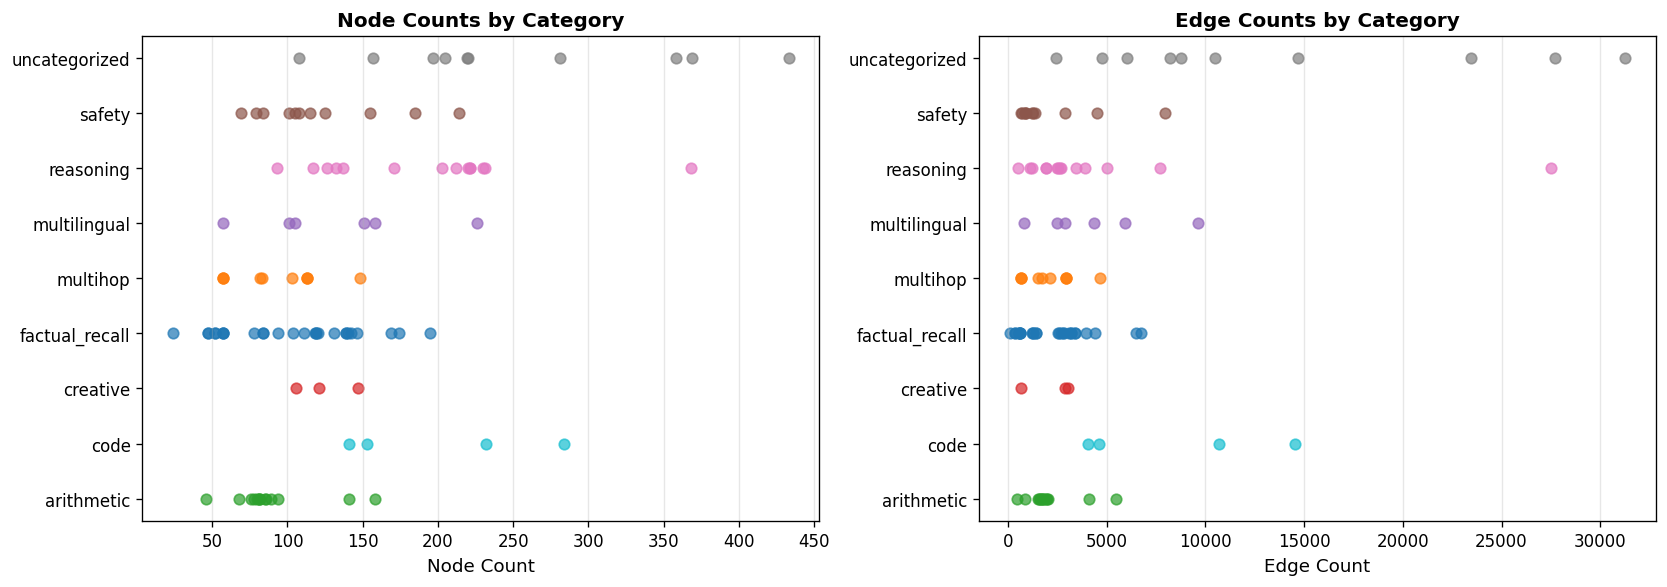

Node count range: 24 - 433 (mean 137)
Edge count range: 82 - 31265 (mean 4065)


In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Node count distribution
node_counts = [g['n_nodes'] for g in summary['graphs']]
edge_counts = [g['n_edges'] for g in summary['graphs']]
categories = [g['category'] for g in summary['graphs']]
unique_cats = sorted(set(categories))

from src.visualization import TASK_COLORS

for cat in unique_cats:
    cat_nodes = [n for n, c in zip(node_counts, categories) if c == cat]
    cat_edges = [e for e, c in zip(edge_counts, categories) if c == cat]
    color = TASK_COLORS.get(cat, '#7f7f7f')
    axes[0].scatter(cat_nodes, [cat]*len(cat_nodes), c=color, s=40, alpha=0.7, label=cat)
    axes[1].scatter(cat_edges, [cat]*len(cat_edges), c=color, s=40, alpha=0.7, label=cat)

axes[0].set_xlabel('Node Count', fontsize=11)
axes[0].set_title('Node Counts by Category', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Edge Count', fontsize=11)
axes[1].set_title('Edge Counts by Category', fontsize=12, fontweight='bold')

for ax in axes:
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Node count range: {min(node_counts)} - {max(node_counts)} (mean {np.mean(node_counts):.0f})")
print(f"Edge count range: {min(edge_counts)} - {max(edge_counts)} (mean {np.mean(edge_counts):.0f})")

## 11. Pairwise Task Comparisons

Which task pairs have the most/least similar motif profiles?

In [16]:
pairwise = summary['pairwise_comparisons']
pairwise_sorted = sorted(pairwise, key=lambda x: x['cosine_similarity'], reverse=True)

print("Most similar pairs:")
for p in pairwise_sorted[:5]:
    print(f"  {p['task_a']} vs {p['task_b']}: cos_sim={p['cosine_similarity']:.3f}, "
          f"{p['n_significant_motifs']} sig. motifs")

print(f"\nLeast similar pairs:")
for p in pairwise_sorted[-5:]:
    print(f"  {p['task_a']} vs {p['task_b']}: cos_sim={p['cosine_similarity']:.3f}, "
          f"{p['n_significant_motifs']} sig. motifs")

Most similar pairs:
  code vs uncategorized: cos_sim=0.998, 0 sig. motifs
  reasoning vs safety: cos_sim=0.998, 0 sig. motifs
  factual_recall vs multihop: cos_sim=0.994, 2 sig. motifs
  arithmetic vs factual_recall: cos_sim=0.994, 1 sig. motifs
  arithmetic vs multihop: cos_sim=0.993, 0 sig. motifs

Least similar pairs:
  creative vs factual_recall: cos_sim=0.950, 1 sig. motifs
  code vs multilingual: cos_sim=0.946, 4 sig. motifs
  creative vs multihop: cos_sim=0.931, 3 sig. motifs
  creative vs uncategorized: cos_sim=0.919, 8 sig. motifs
  code vs creative: cos_sim=0.902, 0 sig. motifs
